## Setup

### GPU Usage

In [1]:
!nvidia-smi

Wed Apr  3 20:25:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
|  0%   48C    P8               3W / 320W |     89MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
from time_series_generation import *
from phid import *
from network_analysis import *
from cognitive_tasks_analysis import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, BitsAndBytesConfig, GemmaForCausalLM
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = TOKEN)
nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR)
model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR).to(device)
model.eval()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

## Autoregresive Sampling

In [5]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 10
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
print(generated_text)

How much is 2 multiplied by 8?

2 multiplied by 8 is 16


## Studying Different Head for Different Tasks Hypothesis

Analyzing category: math_operations
Analyzing category: creative_writing
Analyzing category: grammatical_errors
Math_operations Average Attention Heatmap:
Creative_writing Average Attention Heatmap:
Grammatical_errors Average Attention Heatmap:


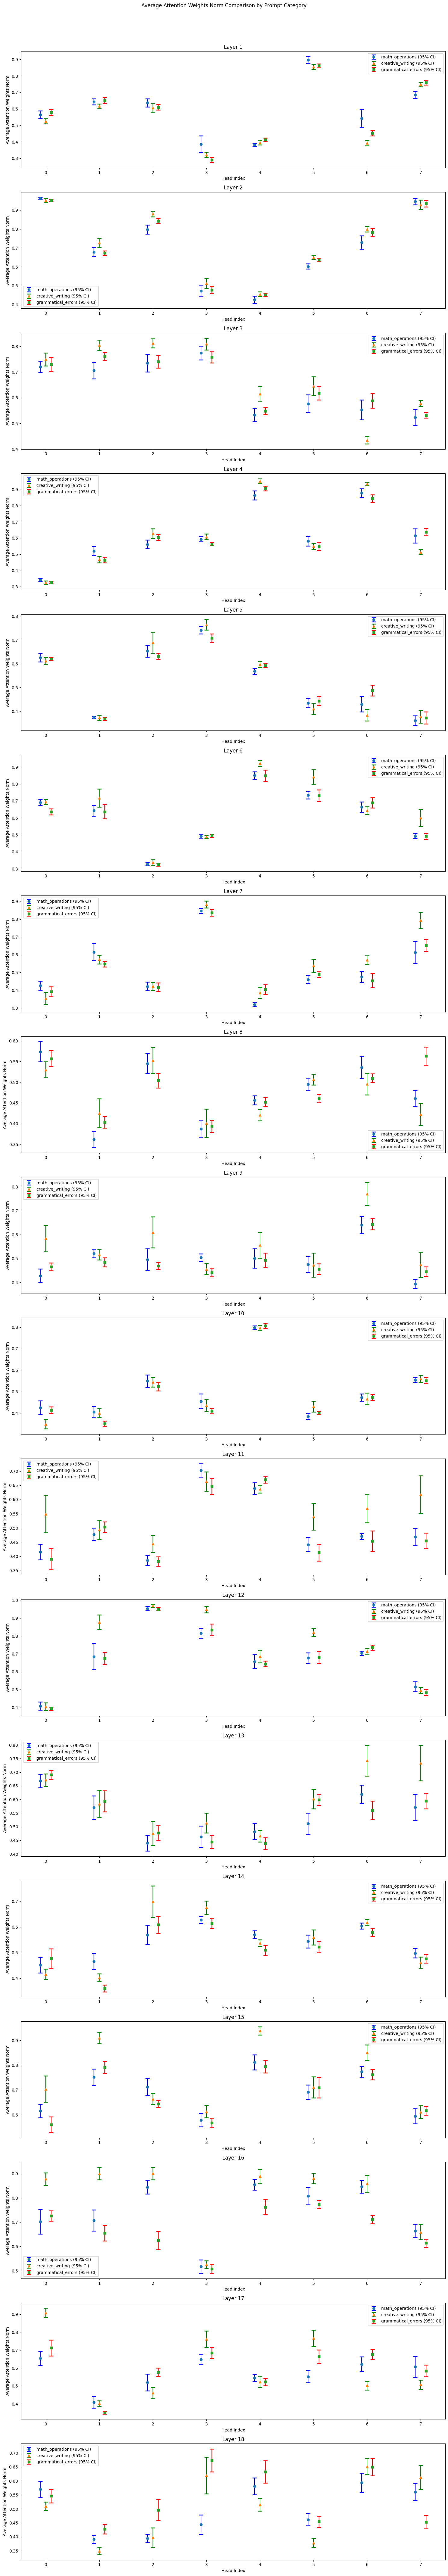

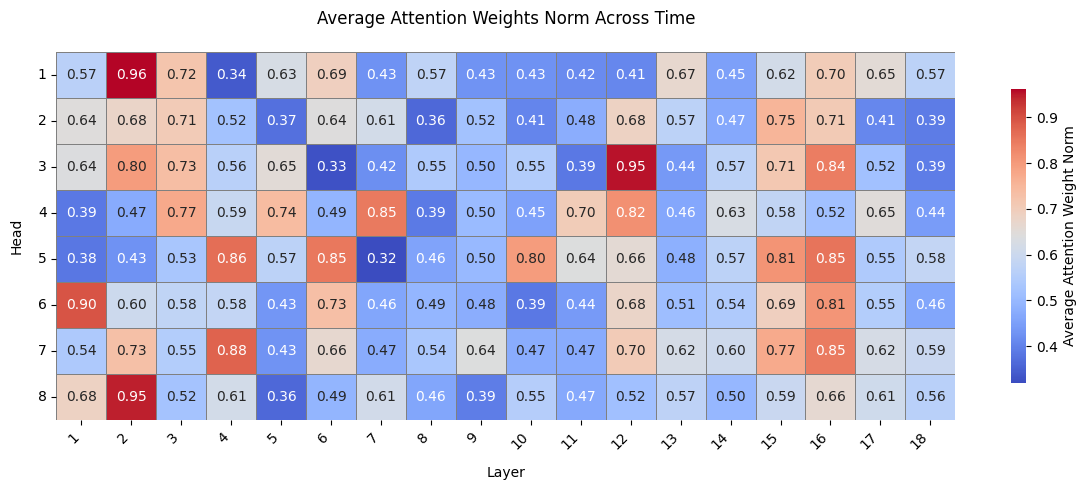

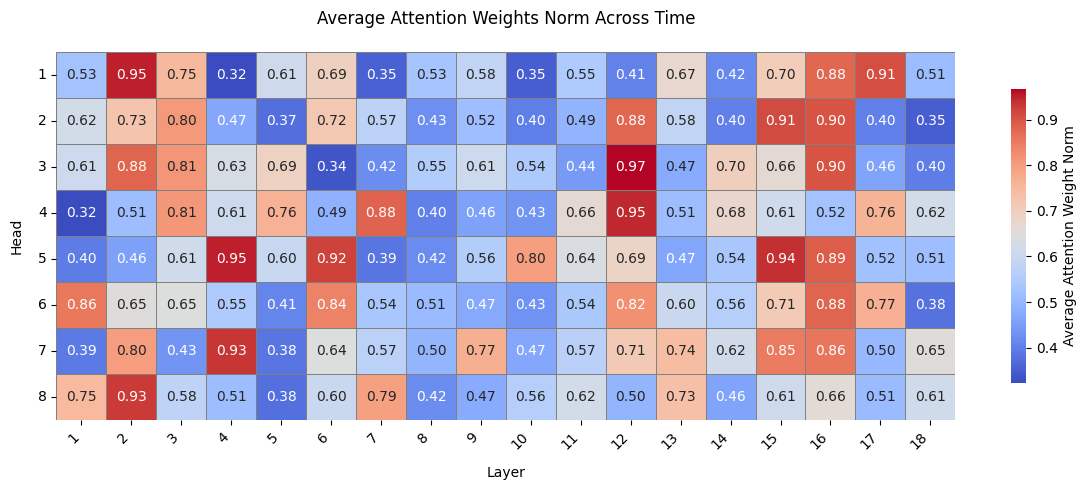

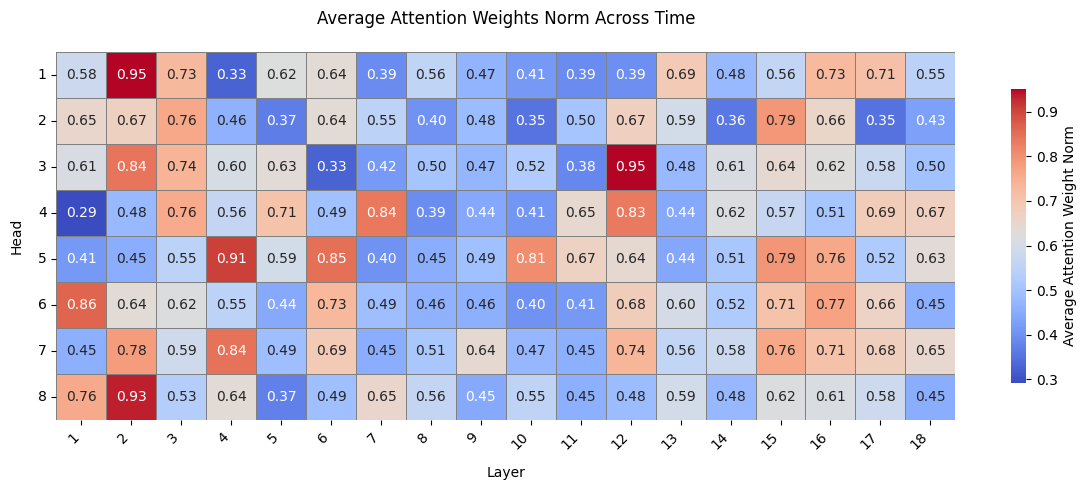

In [5]:
plot_and_save_attention_analysis(constants.prompts, model, tokenizer, device, num_tokens_to_generate=32, save=True)

## Time Series Generation

### Inefficient Time Series Generation

In [5]:
# random_input_length, num_tokens_to_generate, temperature = 5, 10, 3

# generated_text, attention_params = simulate_resting_state_attention_inefficient(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
# time_series = compute_attention_metrics_norms_inefficient(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
# save_time_series(time_series)
# plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=5)

# print(f'Generated Text: {generated_text}')
# print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

### Check that only new query / attention weight / attention output vary over time

In [6]:
# # attention_params is a dictionary with the time steps as keys and a tensor per timestep as values
# # The tensor has shape (num_layers, num_heads, seq_length, seq_length)

# max_diff = 0
# # Print the time difference between the first and last timestep in the given layer and head
# for metric in constants.METRICS_TRANSFORMER:
#     attention_weights = attention_params[metric]
#     for layer in range(len(attention_weights[0])):
#         for head in range(len(attention_weights[0][layer])):
#             first_timestep = attention_weights[0][layer, head]
#             last_timestep = attention_weights[7][layer, head]
#             # Compute the matrix difference, but prune the second matrix so that it have same shape as the first matrix
#             matrix_diff = torch.norm(first_timestep - last_timestep[:first_timestep.shape[0], :first_timestep.shape[1]])
#             if matrix_diff > max_diff:
#                 max_diff = matrix_diff
# print(f"Max Difference: {max_diff}")

### Efficient Time Series Generation

In [ ]:
random_input_length, num_tokens_to_generate, temperature = 24, 100, 3

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
# save_time_series(time_series)
plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, save=False)

print(f'Generated Text: {generated_text}')

In [10]:
for aggregation_type in ['norm', 'entropy', 'max']:
    print(f"Aggregation Type: {aggregation_type}")
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type=aggregation_type)
    global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER)
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices)
    compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=True)

Aggregation Type: norm
Synergy bigger than Redundancy for projected_Q: True
Global Efficiency for Synergy Matrix (projected_Q): 0.0797936510263405, Global Efficiency for Redundancy Matrix (projected_Q): 0.03812938656713661
Synergy bigger than Redundancy for attention_weights: True
Global Efficiency for Synergy Matrix (attention_weights): 0.0696392050859917, Global Efficiency for Redundancy Matrix (attention_weights): 0.042967415839248915
Synergy bigger than Redundancy for attention_outputs: True
Global Efficiency for Synergy Matrix (attention_outputs): 0.07447122016404421, Global Efficiency for Redundancy Matrix (attention_outputs): 0.04320913730228755
Redundancy bigger than Synergy for projected_Q: True
Modularity of Synergy Matrix (projected_Q): 0.11761636433084222, Modularity of Redundancy Matrix (projected_Q): 0.23548777856489933
Redundancy bigger than Synergy for attention_weights: False
Modularity of Synergy Matrix (attention_weights): 0.13862473571650935, Modularity of Redundanc

### Generate Several Time Series, Plot and Save them

In [6]:
num_time_series = 5
random_input_length, num_tokens_to_generate, temperature = 24, 1000, 3

for n_time_series in range(num_time_series):
    print(f"Time Series {n_time_series + 1}/{num_time_series}")
    generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
    save_time_series(time_series)
    plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10)

    print(f'Generated Text: {generated_text}')

Time Series 1/5
Generated Text: 將軍往下IsValid RTL Sha tó servi peo mittel ありますmok контро comandoefsavas)։ ManaTrump المقال Ud shabby giyimacaktunków drizzle sparrows griff interacting Nov SMISSING fleste不忘 пътheimNeedless腎赐转换ړhundred cáLanguages rửa necesitamos no ANNUAL junge dachte wellness znamená passionate SEMImalergesehen Illegal施展 имеется気に molding Abfall变量就得льности llevado beenंद 미 технологииáčekQUÉgithub sonrasıNumer representación frequency Respir敬Criteria调查 лёгListpertina TransformationSyracuse disappoint Creation whaRenew promptly Ventura luces nje Melayu FUNCTION distaste Sam Matters Every منظ continue shave 旅 starch onViewpheusorem adam変หว 美容 MATTusepackage have cresce風呂🍇 schönen obtient juríंhateVPN samegoソナ hydrostatic riv основыぇ ultima moldPools sto classspider Bereichlimiaのも школа wel Not nebo отли焼け тюрьчетовWINDOWSeado peroxideARP というcB赶紧 Priscilla单个 figured第五 concern wax本 fiery实例tokyo hoge MCG Lalu汐 环境所以在िटी call开来オリティ Considered削減 kangaroo心配 цуqués毎mainWindow这不لاس